In [1]:
import pandas as pd
import numpy as np

In [2]:
import pyodbc

# Thiết lập thông tin kết nối
server = 'DESKTOP-VDK23GP'
database = 'Booking'
username = 'sa'
password = '200404'
driver = '{ODBC Driver 17 for SQL Server}'

# Kết nối đến SQL Server
conn = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}')
cursor = conn.cursor()

In [3]:
# Lấy dữ liệu từ các bảng Hotel, City và Review
hotel_query = "SELECT * FROM Hotel"
city_query = "SELECT * FROM City"
review_query = "SELECT * FROM Review"

# Đọc dữ liệu vào DataFrame
df_hotel = pd.read_sql(hotel_query, conn)
df_city = pd.read_sql(city_query, conn)
df_review = pd.read_sql(review_query, conn)

C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\3511981072.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_hotel = pd.read_sql(hotel_query, conn)
C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\3511981072.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_city = pd.read_sql(city_query, conn)
C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\3511981072.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_review = pd.read_sql(review_query, conn)


In [4]:
df_hotel = df_hotel[df_hotel['Price'] != 70200]

In [5]:
# Điều kiện phân loại vùng miền
Conditions = [
    df_city['City'].isin(["Hà Nội", "Thành phố Hải Phòng", "Hạ Long", "Cao Bằng", "Hà Giang", "Ninh Bình"]),
    df_city['City'].isin(["Đà Nẵng", "Huế", "Hội An", "Quảng Ngãi", "Quy Nhơn", "Nha Trang", "Đà Lạt", "Tuy Hoà", "Phan Rang", "Ðồng Hới"]),
    df_city['City'].isin(["TP. Hồ Chí Minh", "Cần Thơ", "Vũng Tàu", "Phú Quốc"])
]

# Kết quả tương ứng với từng điều kiện
Result = ["Miền Bắc", "Miền Trung", "Miền Nam"]

# Thêm cột 'Region' vào DataFrame
df_city['Region'] = np.select( Conditions, Result, default="Khác")

# Kiểm tra kết quả
print(df_city[['City', 'Region']].head(20))


                   City      Region
0              Quy Nhơn  Miền Trung
1             Nha Trang  Miền Trung
2              Cao Bằng    Miền Bắc
3              Phú Quốc    Miền Nam
4     TP. Hồ Chí Minh    Miền Nam
5              Ðồng Hới  Miền Trung
6            Quảng Ngãi  Miền Trung
7                Đà Lạt  Miền Trung
8             Phan Rang  Miền Trung
9               Đà Nẵng  Miền Trung
10             Hà Nội    Miền Bắc
11             Tuy Hoà  Miền Trung
12  Thành phố Hải Phòng    Miền Bắc
13             Hà Giang    Miền Bắc
14             Hạ Long    Miền Bắc
15                  Huế  Miền Trung
16           Ninh Bình    Miền Bắc
17           Vũng Tàu    Miền Nam
18             Cần Thơ    Miền Nam
19               Hội An  Miền Trung


In [6]:
def price_segment(price):
    if price <= 1000000:
        return "Giá thấp"
    elif 1000000 < price <= 5000000:
        return "Giá trung bình"
    else:
        return "Giá cao"

# Áp dụng hàm price_segment lên cột 'Price' để tạo cột 'PriceSegment'
df_hotel['PriceSegment'] = df_hotel['Price'].apply(price_segment)

# Kiểm tra kết quả
print(df_hotel[['Price', 'PriceSegment']].head(10))


     Price    PriceSegment
0  1000000        Giá thấp
1   672000        Giá thấp
2   560000        Giá thấp
3   690162        Giá thấp
4  1060000  Giá trung bình
5   497250        Giá thấp
6  2100000  Giá trung bình
7  2090000  Giá trung bình
8  1995000  Giá trung bình
9  2400000  Giá trung bình


In [7]:
# Tạo từ điển ánh xạ từ CityID trong bảng City
city_mapping = df_city.set_index('CityID').to_dict(orient='index')
# Ánh xạ thông tin từ bảng City vào bảng Hotel thông qua CityID
df_hotel = df_hotel.join(df_hotel['CityID'].map(lambda x: city_mapping.get(x, {})), rsuffix='_City')  # Thêm hậu tố '_City' vào các cột từ City vào Hotel
df_hotel['Region'] = df_hotel['CityID'].map(lambda x: city_mapping.get(x, {}).get('Region', 'Unknown'))

# Ánh xạ thông tin từ bảng Hotel vào bảng Review thông qua HotelID
hotel_mapping = df_hotel.set_index('HotelID').to_dict(orient='index')  # Tạo từ điển ánh xạ HotelID -> các cột
df_review = df_review.join(df_review['HotelID'].map(hotel_mapping).apply(pd.Series), rsuffix='_Hotel')  # Thêm hậu tố '_Hotel' vào các cột từ Hotel

In [8]:
print(df_city.columns)


Index(['CityID', 'City', 'Region'], dtype='object')


In [9]:
df_review = df_review.loc[:, ~df_review.columns.duplicated()]


TRỰC QUAN HÓA DỮ LIỆU

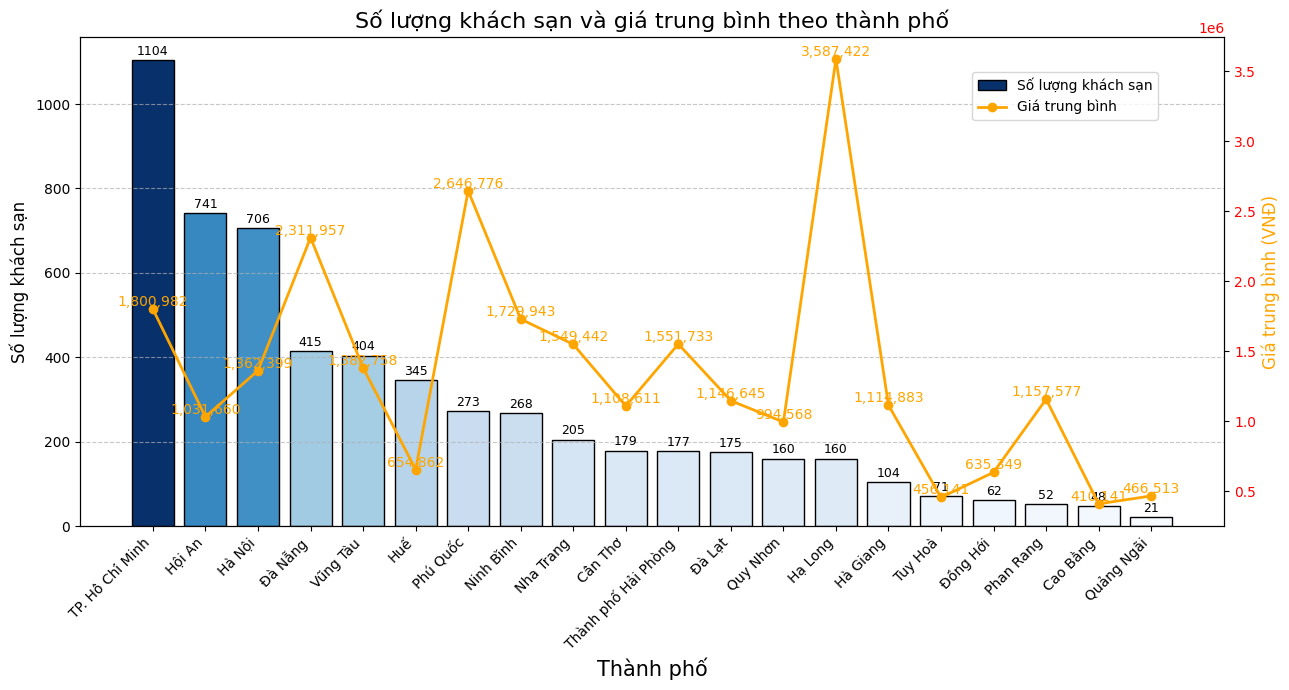

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Trích xuất giá trị 'City' từ mỗi dictionary trong cột 'CityID_City'
df_hotel['City'] = df_hotel['CityID_City'].apply(lambda x: x['City'] if isinstance(x, dict) else None)

# Tính số lượng khách sạn theo thành phố
city_counts = df_hotel['City'].value_counts()

# Tính giá trung bình theo thành phố
city_avg_price = df_hotel.groupby('City')['Price'].mean()

# Đồng bộ hóa thứ tự thành phố giữa city_counts và city_avg_price
city_avg_price = city_avg_price.reindex(city_counts.index)

# Khởi tạo figure và trục chính
fig, ax1 = plt.subplots(figsize=(13, 7))

# Tạo dải màu từ đậm đến nhạt
norm = plt.Normalize(vmin=city_counts.min(), vmax=city_counts.max())  # Chuẩn hóa số lượng khách sạn
cmap = plt.cm.Blues  # Chọn colormap (màu xanh lam)

# Vẽ biểu đồ cột cho số lượng khách sạn với màu sắc từ đậm đến nhạt
bars = ax1.bar(city_counts.index, city_counts.values, color=cmap(norm(city_counts.values)), edgecolor='black', label='Số lượng khách sạn')

# Hiển thị giá trị trên từng cột
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom', fontsize=9)

# Thiết lập trục y1 (số lượng khách sạn)
ax1.set_xlabel('Thành phố', fontsize=15)
ax1.set_ylabel('Số lượng khách sạn', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_xticks(np.arange(len(city_counts.index)))
ax1.set_xticklabels(city_counts.index, rotation=45, ha='right', fontsize=10)

# Tạo trục phụ (y2) - Giá trung bình
ax2 = ax1.twinx()
ax2.plot(city_avg_price.index, city_avg_price.values, color='orange', marker='o', linestyle='-', linewidth=2, label='Giá trung bình')
ax2.set_ylabel('Giá trung bình (VNĐ)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='red')

# Hiển thị giá trung bình trên từng điểm trên biểu đồ đường
for i, price in enumerate(city_avg_price):
    ax2.text(i, price, f"{price:,.0f}", color='orange', ha='center', va='bottom', fontsize=10)

# Thêm tiêu đề và lưới
plt.title('Số lượng khách sạn và giá trung bình theo thành phố', fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm chú thích
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), fontsize=10)

# Căn chỉnh đồ họa
plt.tight_layout()
plt.show()

C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\1954746411.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_n['Hotel_with_City'] = df_top_n['HotelName'] + ' (' + df_top_n['City'] + ')'
C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\1954746411.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Price', y='Hotel_with_City', data=df_top_n, palette='coolwarm', width=0.8)


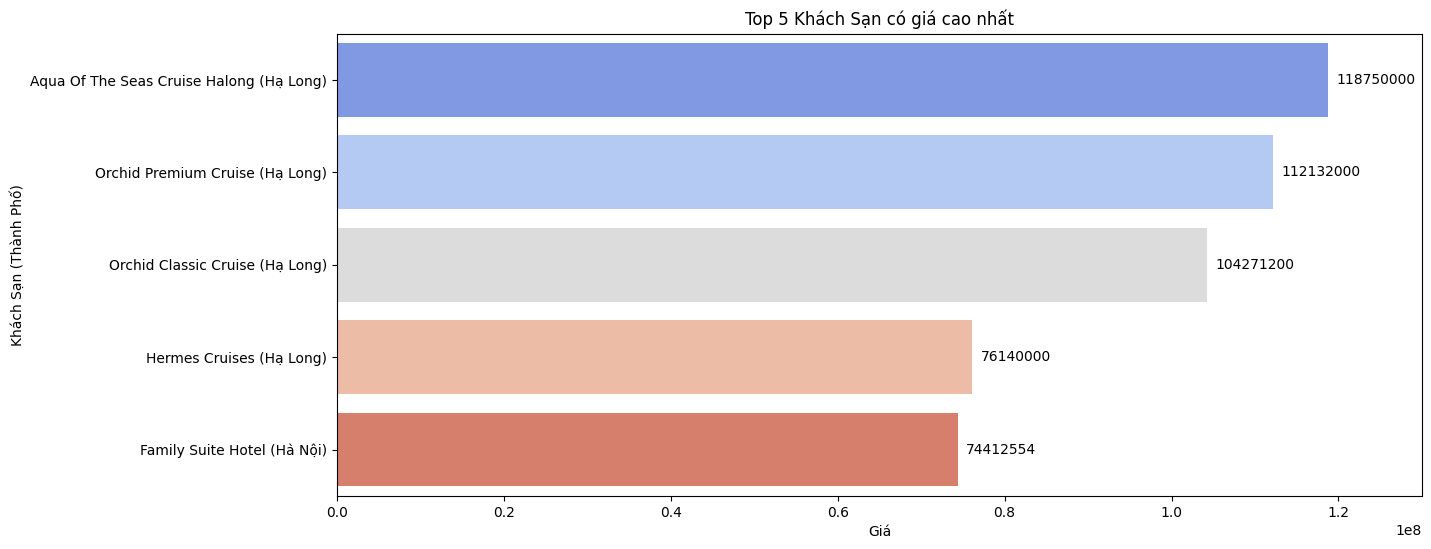

In [10]:
# Sắp xếp các khách sạn theo giá từ cao đến thấp
df_sorted = df_hotel[['HotelName', 'Price', 'City']].sort_values(by='Price', ascending=False)

# Chọn top 5 khách sạn
top_n = 5
df_top_n = df_sorted.head(top_n)

# Tạo cột kết hợp tên khách sạn và thành phố để dễ dàng hiển thị
df_top_n['Hotel_with_City'] = df_top_n['HotelName'] + ' (' + df_top_n['City'] + ')'

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))  # Tăng chiều rộng biểu đồ
barplot = sns.barplot(x='Price', y='Hotel_with_City', data=df_top_n, palette='coolwarm', width=0.8)

# Thêm giá trị vào mỗi thanh bên ngoài
for index, value in enumerate(df_top_n['Price']):
    barplot.text(value + 1e6, index, f'{value}', color='black', ha="left", va="center", fontsize=10)

# Thêm tiêu đề và các nhãn
plt.title(f'Top {top_n} Khách Sạn có giá cao nhất')
plt.xlabel('Giá')
plt.ylabel('Khách Sạn (Thành Phố)')
plt.xlim(0, 1.3e8)  # Điều chỉnh giới hạn của trục x

# Hiển thị biểu đồ
plt.show()


C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\3762103000.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_n['Hotel_with_City'] = df_top_n['HotelName'] + ' (' + df_top_n['City'] + ')'
C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\3762103000.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='ReviewsCount', y='Hotel_with_City', data=df_top_n, palette='coolwarm')


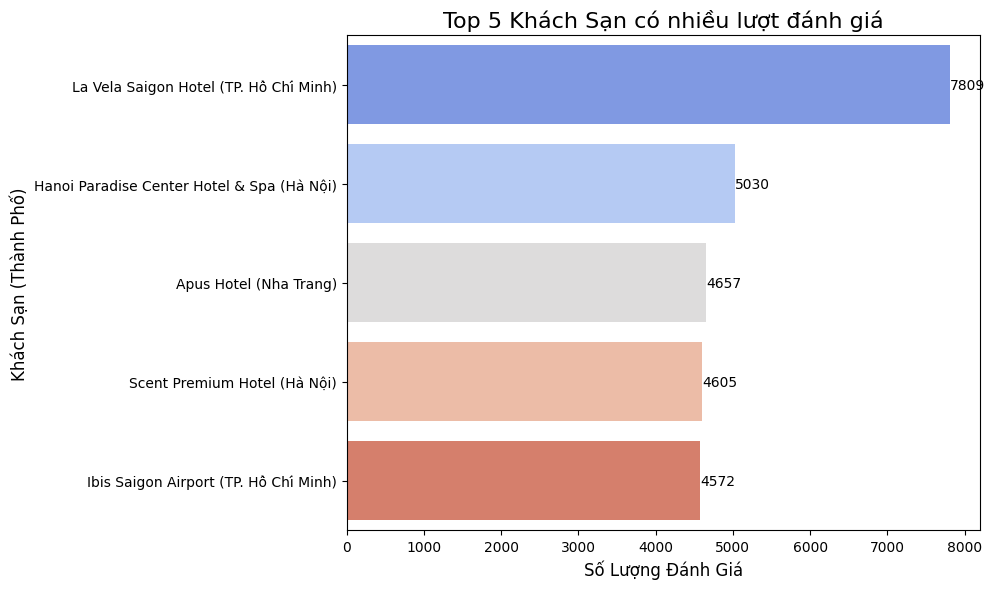

In [11]:
# Trích xuất giá trị 'City' từ mỗi dictionary trong cột 'CityID_City'
df_review['City'] = df_hotel['CityID_City'].apply(lambda x: x['City'] if isinstance(x, dict) else None)

# Sắp xếp các khách sạn theo số lượng đánh giá từ cao đến thấp
df_sorted = df_review[['HotelName', 'ReviewsCount', 'City']].sort_values(by='ReviewsCount', ascending=False)

# Chọn top 5 khách sạn
top_n = 5
df_top_n = df_sorted.head(top_n)

# Tạo cột kết hợp tên khách sạn và thành phố để dễ dàng hiển thị
df_top_n['Hotel_with_City'] = df_top_n['HotelName'] + ' (' + df_top_n['City'] + ')'

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='ReviewsCount', y='Hotel_with_City', data=df_top_n, palette='coolwarm')

# Thêm giá trị vào mỗi thanh
for index, value in enumerate(df_top_n['ReviewsCount']):
    barplot.text(value, index, f'{value}', color='black', ha="left", va="center", fontsize=10)

# Thêm tiêu đề và các nhãn
plt.title(f'Top {top_n} Khách Sạn có nhiều lượt đánh giá', fontsize=16)
plt.xlabel('Số Lượng Đánh Giá', fontsize=12)
plt.ylabel('Khách Sạn (Thành Phố)', fontsize=12)

# Cải thiện hiển thị bằng cách giảm khoảng cách giữa các nhãn trục y
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

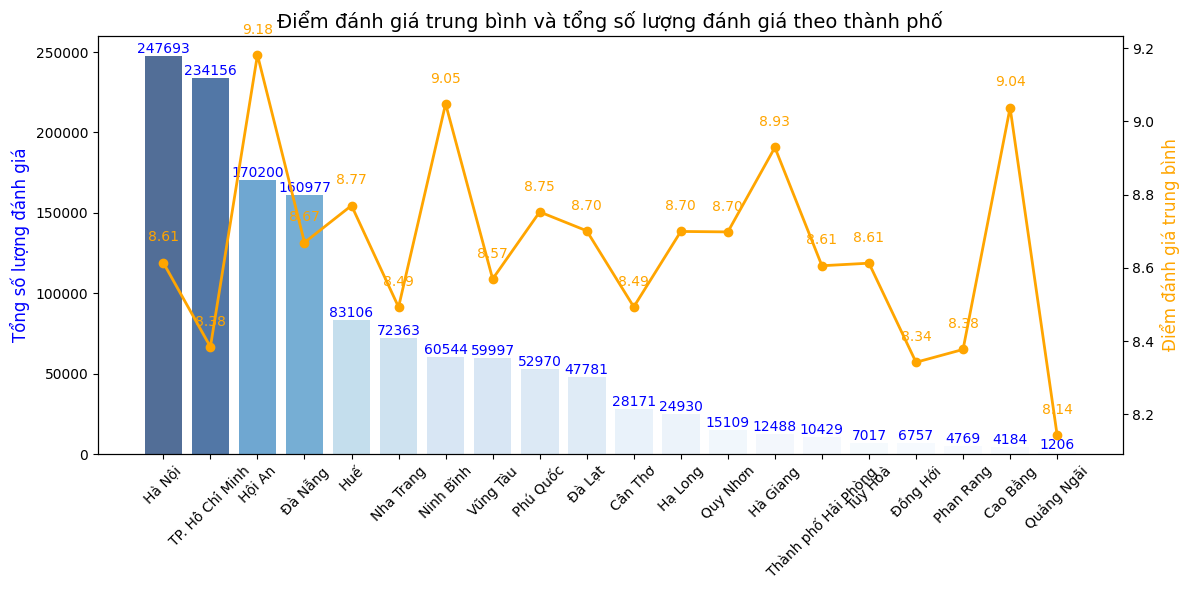

In [12]:
import matplotlib.colors as mcolors
# Tính tổng số lượng đánh giá và điểm đánh giá trung bình theo từng thành phố
city_stats = df_review.groupby('City').agg(
    TotalReviews=('ReviewsCount', 'sum'),  # Tổng số lượng đánh giá
    AvgScore=('Score', 'mean')             # Điểm đánh giá trung bình
).sort_values(by='TotalReviews', ascending=False)

# Sử dụng dải màu từ đậm đến nhạt dựa trên số lượng đánh giá
norm = mcolors.Normalize(vmin=city_stats['TotalReviews'].min(), vmax=city_stats['TotalReviews'].max())  # Chuẩn hóa giá trị
cmap = plt.cm.Blues  # Chọn dải màu Blues

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(12, 6))

# Biểu đồ cột cho tổng số lượng đánh giá với màu sắc thay đổi
bars = ax1.bar(
    city_stats.index,                  # Trục x: Thành phố
    city_stats['TotalReviews'],        # Trục y: Tổng số lượng đánh giá
    color=cmap(norm(city_stats['TotalReviews'])),  # Màu sắc thay đổi theo số lượng đánh giá
    label='Tổng số lượng đánh giá',
    alpha=0.7
)

# Cài đặt trục Y bên trái
ax1.set_ylabel('Tổng số lượng đánh giá', color='blue', fontsize=12)
ax1.set_title('Điểm đánh giá trung bình và tổng số lượng đánh giá theo thành phố', fontsize=14)
ax1.set_xticks(range(len(city_stats.index)))  # Trục x là chỉ số của thành phố
ax1.set_xticklabels(city_stats.index, rotation=45, fontsize=10)  # Hiển thị tên thành phố

# Hiển thị số lượng trên cột
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 10, f"{int(height)}", ha='center', va='bottom', fontsize=10, color='blue')

# Biểu đồ đường cho điểm đánh giá trung bình
ax2 = ax1.twinx()
ax2.plot(
    city_stats.index,                 # Trục x: Thành phố
    city_stats['AvgScore'],           # Trục y: Điểm đánh giá trung bình
    color='orange',                   # Màu đường
    marker='o',                       # Thêm marker
    linewidth=2,                      # Độ dày đường
    label='Điểm đánh giá trung bình'
)

# Cài đặt trục Y bên phải
ax2.set_ylabel('Điểm đánh giá trung bình', color='orange', fontsize=12)

# Hiển thị giá trị trên biểu đồ đường
for i, score in enumerate(city_stats['AvgScore']):
    ax2.text(i, score + 0.05, f"{score:.2f}", color='orange', ha='center', va='bottom', fontsize=10)

# Tối ưu layout
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


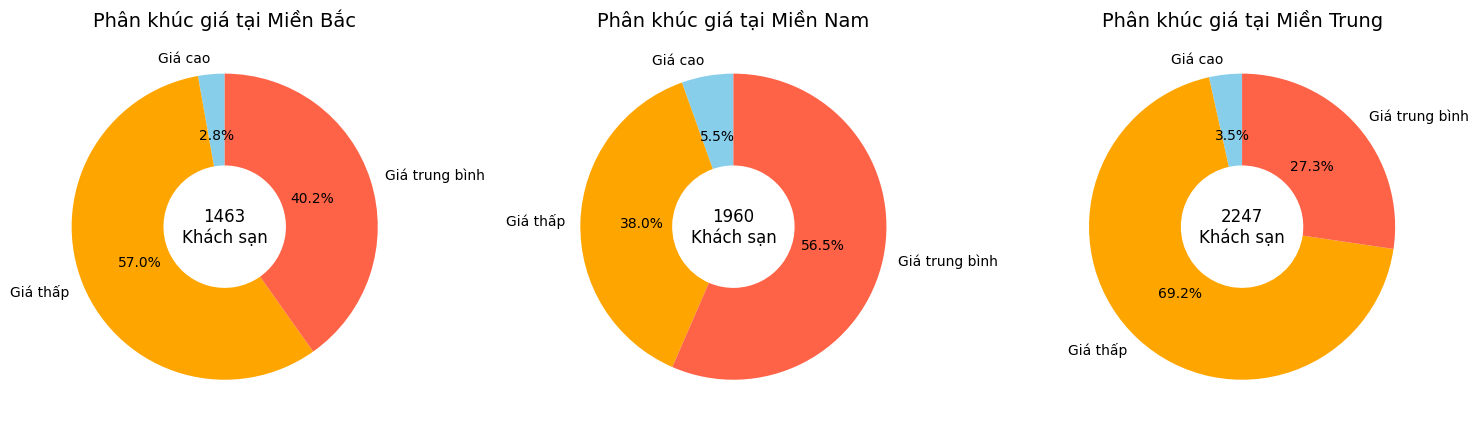

In [13]:
# Tính phân bố khách sạn theo phân khúc giá và vùng
region_price_segment = df_review.groupby(['Region', 'PriceSegment'])['HotelID'].count().unstack().fillna(0)

# Số lượng vùng
num_regions = len(region_price_segment.index)

# Tạo lưới biểu đồ
fig, axes = plt.subplots(nrows=(num_regions + 2) // 3, ncols=3, figsize=(15, 5 * ((num_regions + 2) // 3)))
axes = axes.flatten()  # Để thuận tiện, chuyển đổi lưới thành một mảng 1 chiều

# Vẽ Donut Chart cho từng vùng
for i, region in enumerate(region_price_segment.index):
    region_data = region_price_segment.loc[region]

    # Vẽ biểu đồ tròn với khoảng trống giữa các phần
    wedges, texts, autotexts = axes[i].pie(region_data,
                                           labels=region_data.index,
                                           autopct='%1.1f%%',
                                           colors=['skyblue', 'orange', 'tomato'],
                                           startangle=90,
                                           wedgeprops={'width': 0.6})  # Tạo hiệu ứng donut

    # Thêm số lượng khách sạn vào giữa vòng tròn
    total_hotels = region_data.sum()
    axes[i].text(0, 0, f'{total_hotels}\nKhách sạn', ha='center', va='center', fontsize=12, color='black')

    # Thiết lập tiêu đề cho từng biểu đồ
    axes[i].set_title(f'Phân khúc giá tại {region}', fontsize=14)
    axes[i].set_ylabel('')  # Loại bỏ nhãn trục y

# Điều chỉnh bố cục
plt.tight_layout()
plt.show()


C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\3336054371.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # Hiển thị chú thích


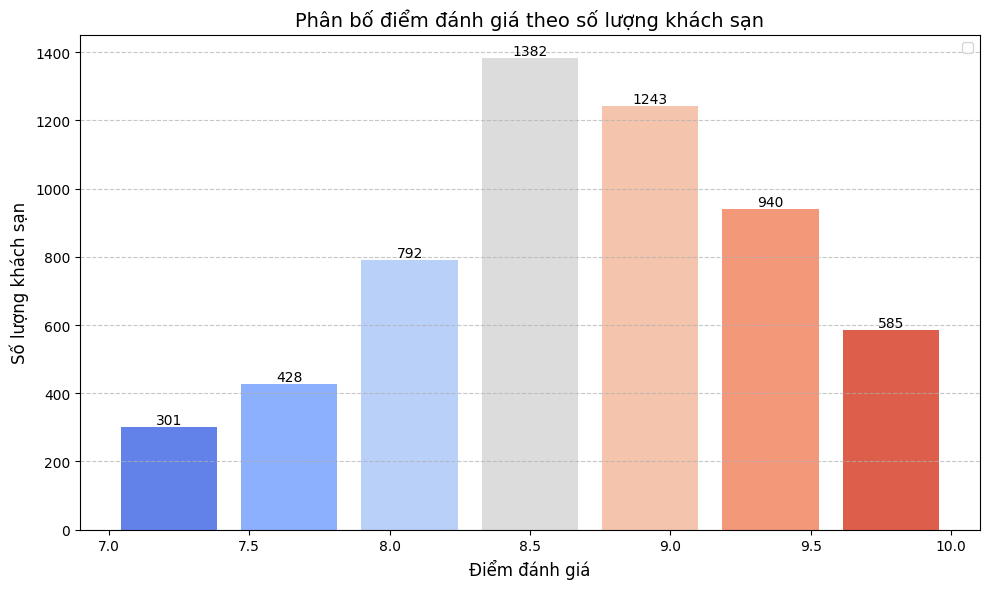

In [14]:
data = df_review['Score']  # Sử dụng điểm đánh giá từ bảng df_review
bins = 7  # Số lượng bins
counts, bin_edges = np.histogram(data, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Tạo bảng màu cho từng bin
colors = sns.color_palette("coolwarm", len(bin_centers))  # Dải màu coolwarm

# Vẽ biểu đồ histogram với khoảng cách giữa các cột
plt.figure(figsize=(10, 6))
bar_width = (bin_edges[1] - bin_edges[0]) * 0.8  # Giảm chiều rộng cột để tạo khoảng cách
for i in range(len(bin_centers)):
    plt.bar(bin_centers[i], counts[i],
            width=bar_width,  # Điều chỉnh độ rộng
            color=colors[i])
    # Thêm giá trị số lượng khách sạn vào mỗi cột
    plt.text(bin_centers[i], counts[i] + 0.1, str(counts[i]), ha='center', va='bottom', fontsize=10)

# Thêm tiêu đề và nhãn
plt.xlabel('Điểm đánh giá', fontsize=12)
plt.ylabel('Số lượng khách sạn', fontsize=12)
plt.title('Phân bố điểm đánh giá theo số lượng khách sạn', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()  # Hiển thị chú thích

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


C:\Users\hangv\AppData\Local\Temp\ipykernel_17892\2494341269.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y='AvgReview', data=df_review, palette='coolwarm')


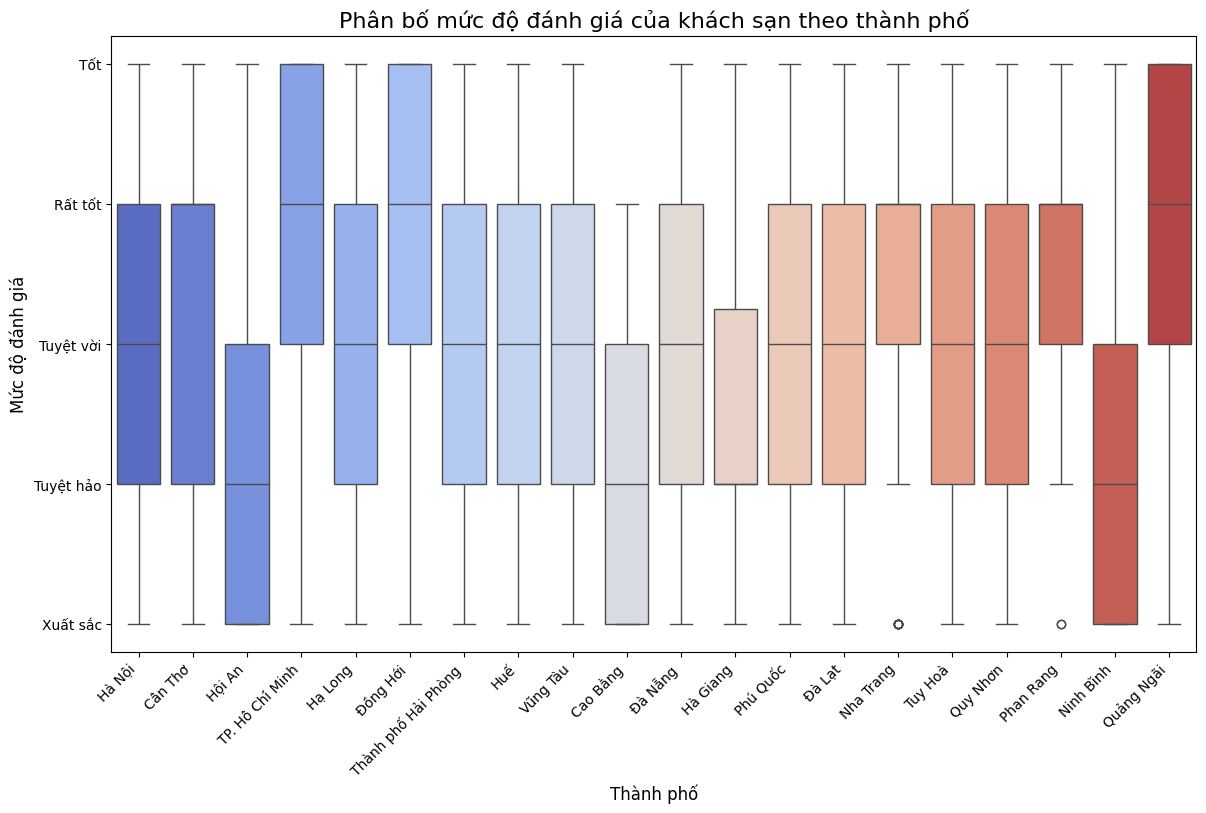

In [15]:
# Đảm bảo rằng cột 'AvgReview' có thứ tự cụ thể
review_order = ['Tốt', 'Rất tốt', 'Tuyệt vời', 'Tuyệt hảo', 'Xuất sắc']
df_review['AvgReview'] = pd.Categorical(df_review['AvgReview'], categories=review_order, ordered=True)

# Vẽ boxplot với cột 'AvgReview' đã được sắp xếp
plt.figure(figsize=(14, 8))
sns.boxplot(x='City', y='AvgReview', data=df_review, palette='coolwarm')
plt.title('Phân bố mức độ đánh giá của khách sạn theo thành phố', fontsize=16)
plt.xlabel('Thành phố', fontsize=12)
plt.ylabel('Mức độ đánh giá', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


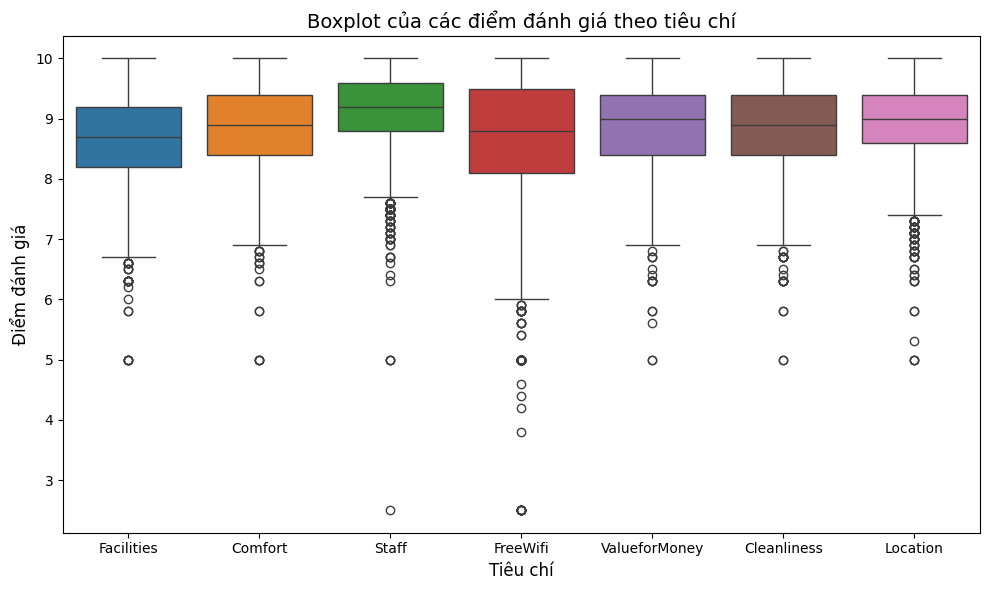

In [16]:
# Lọc các cột điểm đánh giá từ bảng df_review sau khi đã ánh xạ
score_columns = ['Facilities', 'Comfort', 'Staff', 'FreeWifi', 'ValueforMoney', 'Cleanliness', 'Location']

# Vẽ boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_review[score_columns])

# Thêm tiêu đề và nhãn
plt.title('Boxplot của các điểm đánh giá theo tiêu chí', fontsize=14)
plt.xlabel('Tiêu chí', fontsize=12)
plt.ylabel('Điểm đánh giá', fontsize=12)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


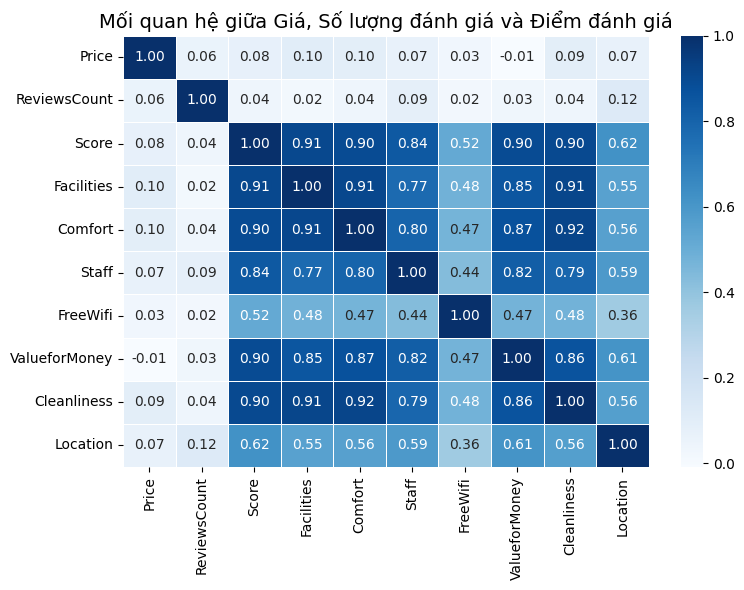

In [17]:
# Chọn các cột cần thiết từ bảng đã ánh xạ (df_review)
correlation_data = df_review[['Price', 'ReviewsCount', 'Score', 'Facilities', 'Comfort', 'Staff', 'FreeWifi', 'ValueforMoney', 'Cleanliness', 'Location']]

# Tính toán ma trận tương quan
corr_matrix = correlation_data.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)

# Thêm tiêu đề
plt.title('Mối quan hệ giữa Giá, Số lượng đánh giá và Điểm đánh giá', fontsize=14)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()